In [1]:
from __future__ import absolute_import, division, print_function

# Passes sold: cohort analysis, growth and forecasting

Data extracted from the monthly operating reports.

## Imports

In [2]:
import datetime
import os

import numpy as np
import pandas as pd

from scipy import optimize
from scipy.optimize import curve_fit
from dateutil.relativedelta import relativedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

## Month/month growth in annual subscriptions

In [3]:
data_dir = os.path.join(os.getcwd(),'..','..','data')
df = pd.read_csv(os.path.join(data_dir,'citibike_sales.csv'))
df.head()

,year,month,yearly,weekly,three_day,daily,casual,active_annual_members
0,2013,6,26515,8044,0,67794,75838,52130
1,2013,7,14185,5980,0,49021,55001,66315
2,2013,8,10823,5244,0,51637,56881,77138
3,2013,9,8103,4634,0,52045,56679,85241
4,2013,10,7901,3386,0,34234,37620,93124


In [4]:
# convert year and month to datetime object
df['date'] = df['year'].apply(str) + '-' + df['month'].apply(str)
df['date'] = df['date'].apply(pd.to_datetime)

In [5]:
# Calculate m/m change in % of active_annual_members
df['mth_over_mth'] = 0
for idx in range(df.shape[0]-1):
    tmp = ((df['active_annual_members'].iloc[idx+1] - 
            df['active_annual_members'].iloc[idx]) / 
           df['active_annual_members'].iloc[idx]) * 100
    df['mth_over_mth'].iloc[idx+1] = tmp
    
    

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
df.head()

,year,month,yearly,weekly,three_day,daily,casual,active_annual_members,date,mth_over_mth
0,2013,6,26515,8044,0,67794,75838,52130,2013-06-01,0.000000
1,2013,7,14185,5980,0,49021,55001,66315,2013-07-01,27.210819
2,2013,8,10823,5244,0,51637,56881,77138,2013-08-01,16.320591
3,2013,9,8103,4634,0,52045,56679,85241,2013-09-01,10.504550
4,2013,10,7901,3386,0,34234,37620,93124,2013-10-01,9.247897


## Annual Passes

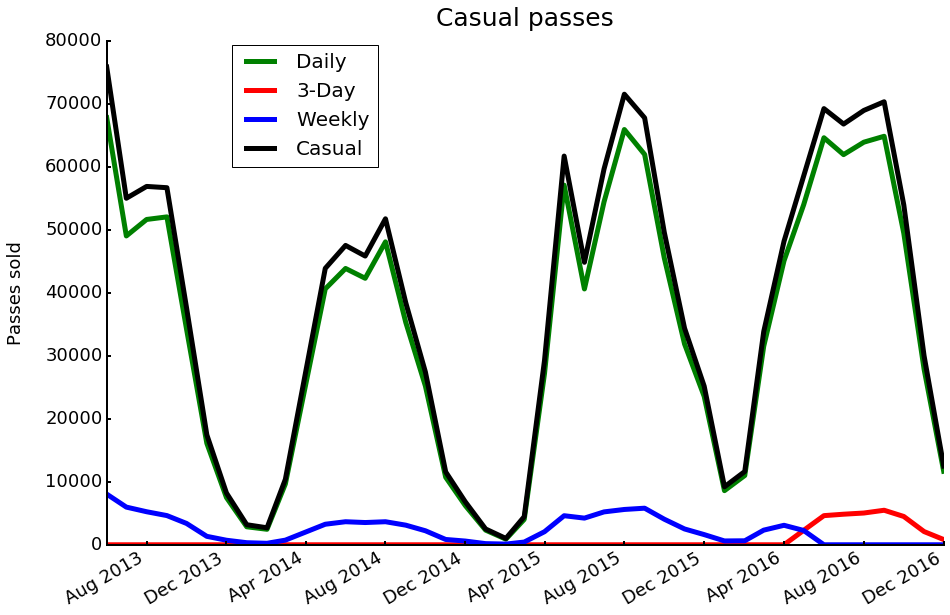

In [7]:
# Plot the contributions of various passes to total casual sales
dates = df['date'][df['active_annual_members'] > 0].tolist()
weekly = df['weekly'][df['active_annual_members'] > 0].tolist()
daily = df['daily'][df['active_annual_members'] > 0].tolist()
three_day = df['three_day'][df['active_annual_members'] > 0].tolist()
casual = df['casual'][df['active_annual_members'] > 0].tolist()
#
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,daily,'g-', alpha=1,lw=5, label='Daily')
plt.plot(dates,three_day,'r-', alpha=1,lw=5, label='3-Day')
plt.plot(dates,weekly,'b-', alpha=1,lw=5, label='Weekly')
plt.plot(dates,casual,'k-', alpha=1,lw=5, label='Casual')

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Casual passes', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.legend(prop={'size': 20},loc=(0.15,0.75))



Casual pass numbers are dominated by daily passes.

## Annual Passes

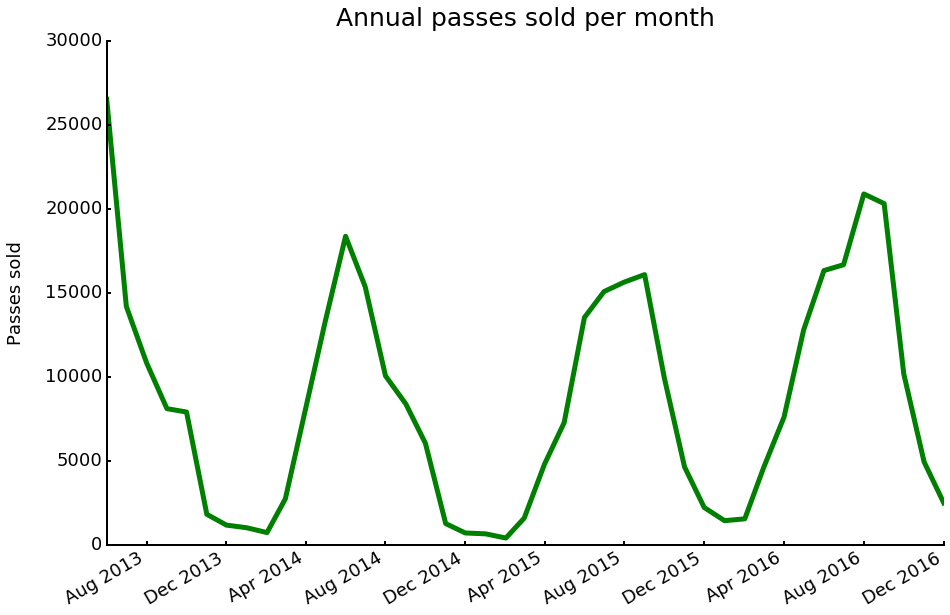

In [8]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
yearly = df['yearly'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')





Strong seasonality in sales of annual passes.

## Fit data - sinusodial function

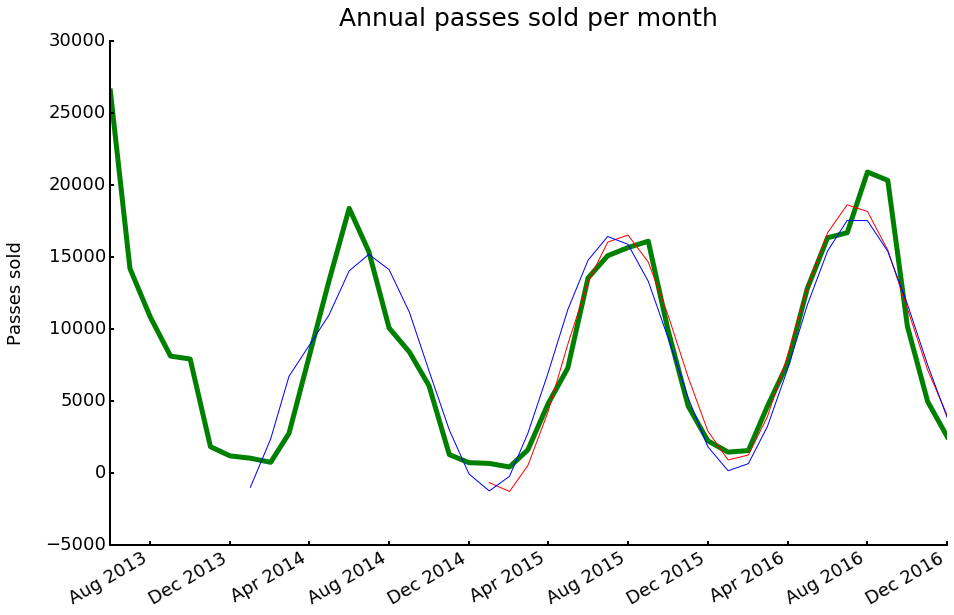

In [9]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
yearly = df['yearly'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Fit data - years 2015+2016
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()
# Generate input data for fitting function
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
tX = yearly
# Fit the data
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [10000, 01.0, 4.5, 1000.] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
# plot results
time = np.linspace(Tx.min(), Tx.max(), 100)
plt.plot(dates, fitfunc(p1, Tx), "r-")  # Plot of the fit

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Fit data - years 2014-2016
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
dates = df['date'][(df['active_annual_members'] > 0) &                   
                   (df['year'] >= 2014)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2014)].tolist()
# Generate input data for fitting function
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
tX = yearly
# Fit the data
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [10000, 01.0, 4.5, 1000.] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
# plot results
time = np.linspace(Tx.min(), Tx.max(), 100)
plt.plot(dates, fitfunc(p1, Tx), "b-")  # Plot of the fit


## Fit data with changing amplitude and forecast

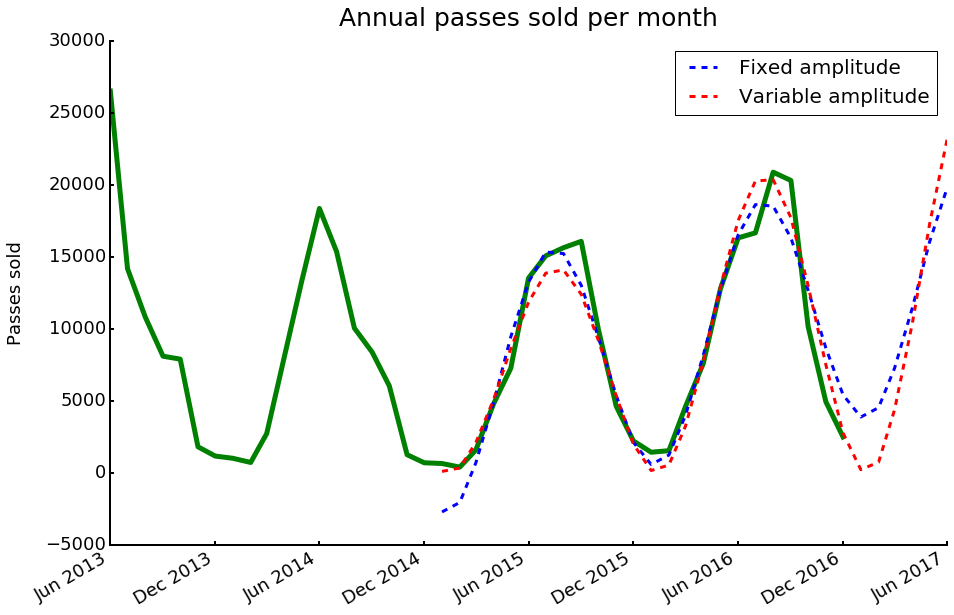

In [10]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
yearly = df['yearly'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Fit data - Constant amplitude
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()# data points
# Generate input data for fitting function
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Fit functions
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/12.*x+p[2]) + p[3]*x # Target function, fixed period
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
# p0 = [10000, 01.0, 4.5, 1000.] # Initial guess for the parameters
p0 = [8e3, 11.5, 4.2, 300.] 
# amplitude, frequency,  , slope
# perform fit
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
# Prepare new data for forecast
new_x = dates[:]
add_months = np.arange(6)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)
# Show the fit
plt.plot(new_x, fitfunc(p1, new_Tx), "b--", lw=3, label='Fixed amplitude')  # Plot of the fit

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Fit data - Variable amplitude
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()
# Generate input data for fitting function
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Fit functions
fitfunc = lambda p, x: p[0]*x*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
fitfunc = lambda p, x: p[0]*x*np.cos(2*np.pi/12.*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
# p0 = [1000, 1.5, 19.5, 1000.] # Initial guess for the parameters
p0 = [250, 12., 4.2, 300.] 
# perform fit
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
# Prepare new data for forecast
new_x = dates[:]
add_months = np.arange(6)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)
# Plot results
plt.plot(new_x, fitfunc(p1, new_Tx), "r--", lw=3, label='Variable amplitude')  # Plot of the fit

# Add legend
plt.legend(prop={'size': 20})


## Similar fit as above, but in casual passes

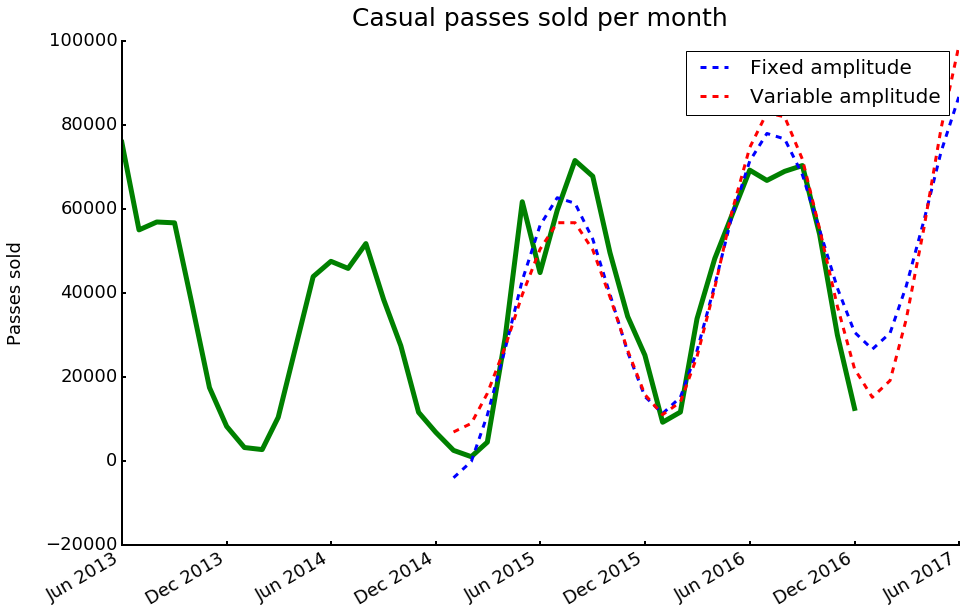

In [11]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
yearly = df['casual'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Casual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Fit data - Same amplitude
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['casual'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()
# Generate input data for fitting function
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Fit functions
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/12.*x+p[2]) + p[3]*x # Target function, fixed period
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
# p0 = [10000, 01.0, 4.5, 1000.] # Initial guess for the parameters
p0 = [8e3, 11.5, 4.2, 300.] 
# amplitude, frequency,  , slope
# perform fit
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
# Prepare new data for forecast
new_x = dates[:]
add_months = np.arange(6)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)
plt.plot(new_x, fitfunc(p1, new_Tx), "b--", lw=3, label='Fixed amplitude')  # Plot of the fit

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Fit data - Variable amplitude
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['casual'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()
# Generate input data for fitting function
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Fit functions
fitfunc = lambda p, x: p[0]*x*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
fitfunc = lambda p, x: p[0]*x*np.cos(2*np.pi/12.*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
# p0 = [1000, 1.5, 19.5, 1000.] # Initial guess for the parameters
p0 = [250, 12., 4.2, 300.] 
# perform fit
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))
# Prepare new data for forecast
new_x = dates[:]
add_months = np.arange(6)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)
plt.plot(new_x, fitfunc(p1, new_Tx), "r--", lw=3, label='Variable amplitude')  # Plot of the fit

# add legend
plt.legend(prop={'size': 20})



## Fit annual pass sale data with Gaussians

In [12]:
#Gaussian function
def gauss(x, a, x0, sigma):
    """
    Simple gaussian function.
    """
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def double_gauss(x, a, b, x0, sigma, m, off):
    """
    Combination of two Gaussians. Same sigma, but different 
    peak height allowed. Added a linear slope underneath. 
    Offset fixed to 12 data points.
    """
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)) +
            a*b*np.exp(-(x-x0-12.)**2/(2*sigma**2)) +
            m*x+off)

def double_hump_gauss(x, a, a2, a3, b, x0, x1, sigma, sigma2, m, off):
    """
    Combination of two Gaussians systems. Each system consist of two Gaussians. 
    Relative strength of the two Gaussians is free, sigma is constant within 
    each system. Added a linear slope underneath. Offset between systems fixed 
    to 12 data points.
    """
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)) + a2*np.exp(-(x-x0-x1)**2/(2*sigma2**2)) +
            a*b*np.exp(-(x-x0-12.)**2/(2*sigma**2)) + a3*np.exp(-(x-x0-x1-12)**2/(2*sigma2**2))+
            m*x+off)

def double_gauss_nooff(x, a, b, x0, sigma):
    """
    Combination of two Gaussians. Same sigma, but different 
    peak height allowed. Added a linear slope underneath. 
    Offset fixed to 12 data points. No additional offset.
    """
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)) +
            a*b*np.exp(-(x-x0-12.)**2/(2*sigma**2)))

def triple_gauss(x, a, b, x0, sigma, m, off):
    """
    Combination of three Gaussians. Peak height of third Gaussian 
    fixed to 2 times the (fitted) peak ratio between the first and 
    second. All Components have the same sigma. Added a linear slope 
    underneath. Distance between adjacent Gaussians fixed to 12 data points. 
    """
    return (a*np.exp(-(x-x0)**2/(2*sigma**2))+
            a*b*np.exp(-(x-x0-12.)**2/(2*sigma**2))+
            b*a*b*np.exp(-(x-x0-12.-12.)**2/(2*sigma**2))+
            m*x+off)




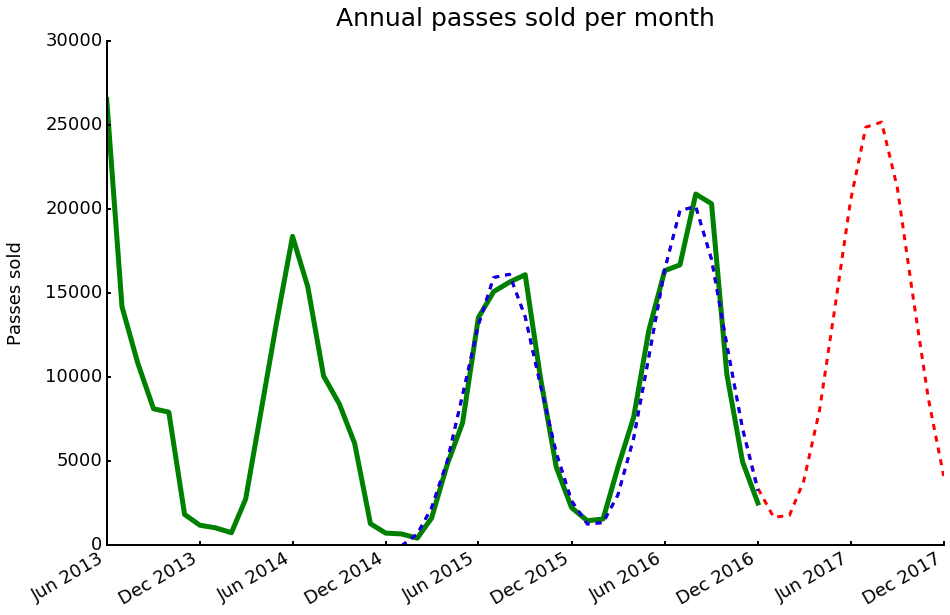

In [13]:
# Plot data
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2013)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2013)].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.ylim(0,30000)
plt.xlim(dates[0],dates[-1]+ relativedelta(months=12))


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Fit data
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()


# Generate input data for fitting function
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Set boundaries and starting values
param_bounds=([-np.inf,0,-np.inf],[np.inf,2,np.inf])
p0 = [1.7e4,1.3,27.,2.3,2.3,-400.]
param_bounds = ([1e4,1,25,0,0,-np.inf],
               np.inf)
# Perform the fit
popt, pcov = curve_fit(double_gauss, Tx, tX, bounds=param_bounds)

# save result for later
popt_dg = popt[:]

# Prepare new data for forecast
new_x = dates[:]
add_months = np.arange(12)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)

# Plot initial fit and forecast
plt.plot(new_x,triple_gauss(new_Tx, *popt),'r--',lw=3)
plt.plot(dates,double_gauss(Tx, *popt),'b--',lw=3)

# Save figure
plt.savefig(os.path.join(data_dir,'plots','monthly_variations_in_annual_passes_sold_03.png'), bbox_inches='tight')




## Forecast for 2017 per month

In [14]:
sales = triple_gauss(new_Tx, *popt)
for idx,month in enumerate(new_x):
    print(month,sales[idx])


2015-01-01 00:00:00 -53.491191189
2015-02-01 00:00:00 648.289830877
2015-03-01 00:00:00 2206.29984968
2015-04-01 00:00:00 4994.8135656
2015-05-01 00:00:00 8928.41495751
2015-06-01 00:00:00 13088.4086394
2015-07-01 00:00:00 15914.8218761
2015-08-01 00:00:00 16109.0893139
2015-09-01 00:00:00 13576.7707256
2015-10-01 00:00:00 9503.16368202
2015-11-01 00:00:00 5491.53392371
2015-12-01 00:00:00 2627.54005557
2016-01-01 00:00:00 1243.86445011
2016-02-01 00:00:00 1327.63534091
2016-03-01 00:00:00 2968.2221396
2016-04-01 00:00:00 6345.43026543
2016-05-01 00:00:00 11216.1281572
2016-06-01 00:00:00 16387.1372681
2016-07-01 00:00:00 19902.9837712
2016-08-01 00:00:00 20144.5695843
2016-09-01 00:00:00 16993.749685
2016-10-01 00:00:00 11925.2159427
2016-11-01 00:00:00 6933.79808393
2016-12-01 00:00:00 3370.31125842
2017-01-01 00:00:00 1648.69102938
2017-02-01 00:00:00 1752.92186173
2017-03-01 00:00:00 3794.20047288
2017-04-01 00:00:00 7996.24738664
2017-05-01 00:00:00 14056.549186
2017-06-01 00:00:0

## Fit with two gaussians per hump

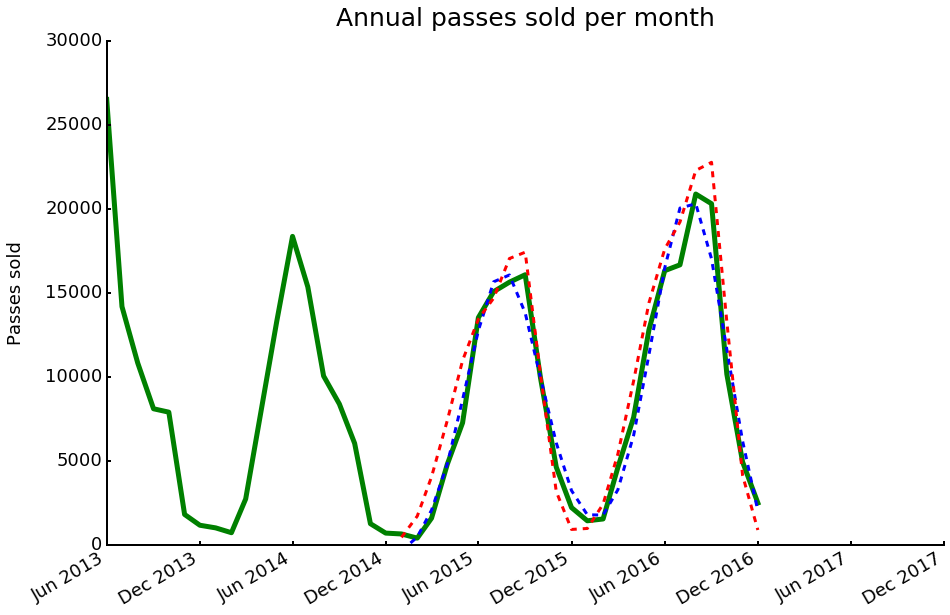

In [15]:
# Plot data
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2013)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2013)].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,yearly,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.ylim(0,30000)
plt.xlim(dates[0],dates[-1]+ relativedelta(months=12))


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Fit data
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()


# Generate input data for fitting function
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Set boundaries and starting values
param_bounds=([-np.inf,0,-np.inf],[np.inf,2,np.inf])
p0 = [1.4e4,1e4,1.3e4,1.3,25.5,2.5,2.3,1.0,2.3,-400.]
param_bounds = ([1e4,1,1,1,25,0,0,0,0,-np.inf],
               [np.inf,np.inf,np.inf,np.inf,np.inf,3,np.inf,1e3,np.inf,np.inf])

# Perform the fit
popt_dh, pcov_dh = curve_fit(double_hump_gauss, Tx, tX, bounds=param_bounds)
# Plot the results
plt.plot(dates,double_hump_gauss(Tx, *popt_dh),'b--',lw=3)
# Plot the initial values
plt.plot(dates,double_hump_gauss(Tx, *p0),'r--',lw=3)


In [16]:
# Estimate
yearly_est = double_hump_gauss(Tx, *popt_dh)

# Subtract estimate from data
diff = [x-y for x,y in zip(yearly,yearly_est)]
rms_diff = np.sqrt(np.mean(np.square(np.array(diff))))
rms_diff

# [  1.68019035e+04   1.24423689e+00   2.65663114e+01   2.36858168e+00
#    2.74958286e-10  -4.13651675e+02]

1358.7547500565997

## Subtract the fit from the data and show the variation in the 'error'

In [17]:
# Observed data
dates = df['date'][(df['active_annual_members'] > 0) & 
                  (df['year'] >= 2015)].tolist()
yearly = df['yearly'][(df['active_annual_members'] > 0) & 
                     (df['year'] >= 2015)].tolist()

# Estimate
yearly_est = double_gauss(Tx, *popt_dg)

# Subtract estimate from data
diff = [x-y for x,y in zip(yearly,yearly_est)]
rms_diff = np.sqrt(np.mean(np.square(np.array(diff))))
rms_diff


1420.7738666919422

(735599.0, 736664.0)

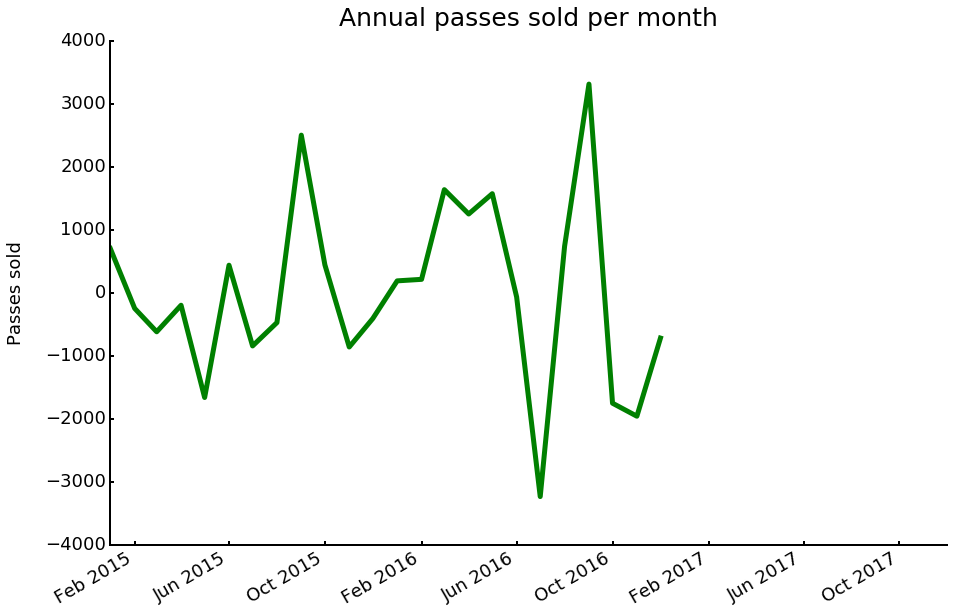

In [18]:
# plot the difference
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,diff,'g-', alpha=1,lw=5)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# plt.ylim(-10,10)
plt.xlim(dates[0],dates[-1]+ relativedelta(months=12))


## Month-over-month change in subscribers

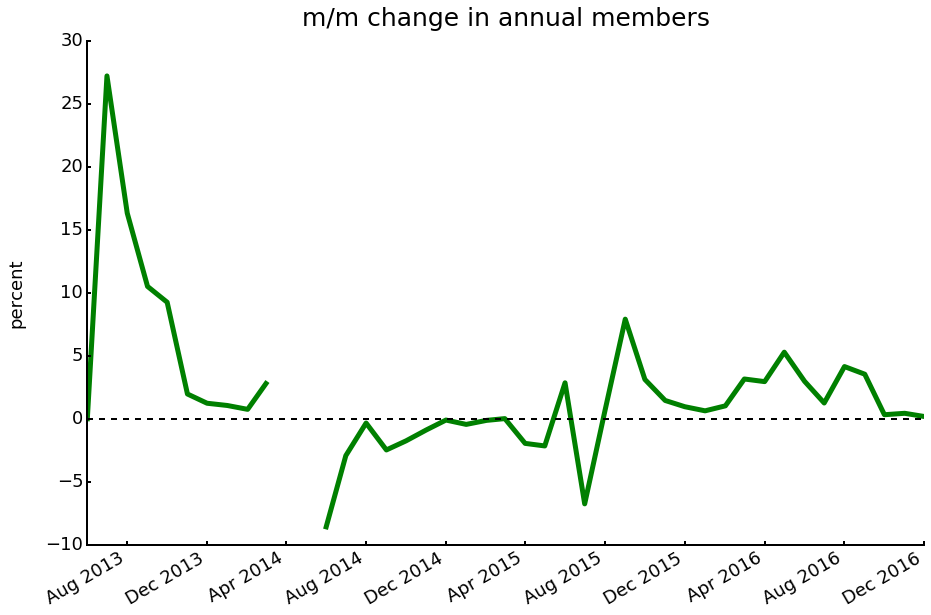

In [19]:
dates = df['date'][df['active_annual_members'] > 0].tolist()
rate = df['mth_over_mth'][df['active_annual_members'] > 0].tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,rate,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('percent', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('m/m change in annual members', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# highlight zero level
plt.plot([dates[0],dates[-1]],[0.,0.],ls='--',color='k',lw=2)



## Year-over-year change in subscribers

In [20]:
# Year-over-year growth in annual subscriptions
years = df['year'].unique().tolist()
growth = years[:]
for idx,year in enumerate(years):
    if idx == 0:
        growth[idx] = 0
    else:
        last_year = df['yearly'][df['year'] == years[idx-1]].sum()
        if years[idx-1] == 2013:
            # Account for the fact that for 2013 we only have data from June onwards.
            # The other years have a rateio of 1.3 for annual subscription for 
            # the full years vs. months 6 through 12.
            last_year = last_year * 1.3
        this_year = df['yearly'][df['year'] == years[idx]].sum()
        if years[idx-1] == 2014:
            # April 2014 missing. For 2015 and 2016, the annual subscriptions in April
            # are a factor of ~1.5 smaller than the annual subscriptions in May.
            last_year = last_year + 13303 / 1.5
        if years[idx] == 2014:
            this_year = this_year + 13303 / 1.5
        print(last_year,this_year)
        growth[idx] = (this_year-last_year)/last_year
    

91663.0 86818.6666667
86818.6666667 91832
91832 119758


In [21]:
growth = [x*100  for x in growth]


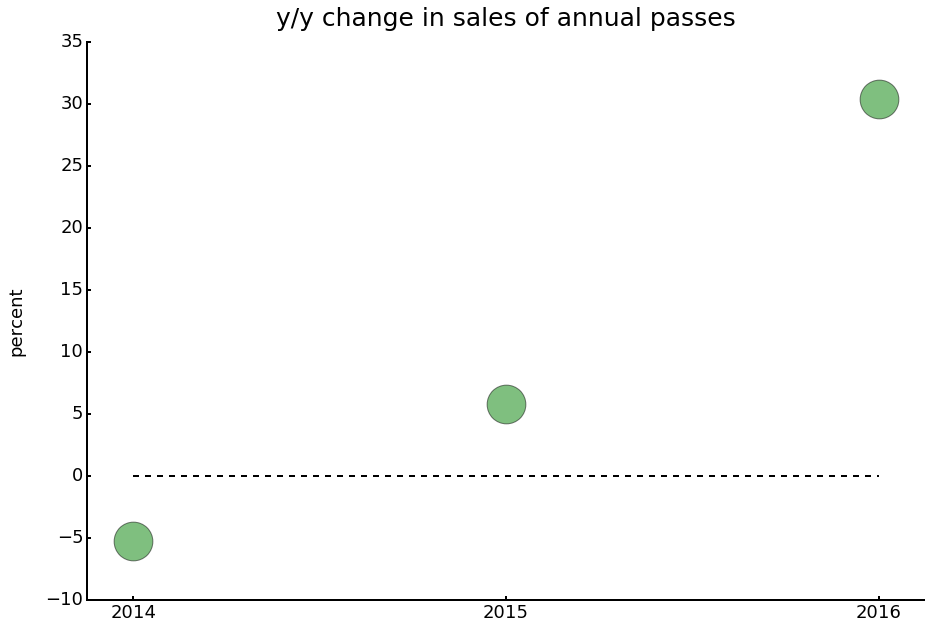

In [22]:

fig, ax = plt.subplots(figsize=(15, 10))
# plt.plot(years,growth,'g-', alpha=1,lw=5)
plt.scatter(years[1:],growth[1:], s=1500, c='green', alpha=0.5)
plt.xticks(years[1:], years[1:], horizontalalignment='center')
# rotate and align the tick labels so they look better
# fig.autofmt_xdate()
# use a more precise date string for the x axis locations in the
# toolbar
# ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# plt.title('fig.autofmt_xdate fixes the labels')
# ax.fill_between(dates, 0, trips, facecolor='green', alpha=0.5)
# plt.xlabel('Date', fontsize=18)
plt.ylabel('percent', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('y/y change in sales of annual passes', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# highlight zero level
plt.plot([2014,2016],[0.,0.],ls='--',color='k',lw=2)

plt.savefig(os.path.join(data_dir,'plots','year_over_year_change_of_annual_passes_sold.pdf'), bbox_inches='tight')



## Calculate per month the change in subscribers w.r.t. to the same month the year before

In [23]:
# Year-over-year growth in annual subscriptions
years = [2014,2015,2016]
months = list(np.arange(1,13))
growth_mom = []
for idx,year in enumerate(years):
    if year > 2014:
        for midx,month in enumerate(months):
            last_year = df['yearly'][(df['year'] == years[idx-1]) & 
                                     (df['month'] == month)].sum()
            this_year = df['yearly'][(df['year'] == years[idx]) & 
                                     (df['month'] == month)].sum()
            if years[idx-1] == 2014 and month == 4:
                # April 2014 missing. For 2015 and 2016, the annual subscriptions in April
                # are a factor of ~1.5 smaller than the annual subscriptions in May.
                last_year = 13303 / 1.5
            print(last_year,this_year,(this_year-last_year)/last_year)
            growth_mom.append((this_year-last_year)*100/last_year)



1013 651 -0.357354392892
726 402 -0.446280991736
2736 1589 -0.419225146199
8868.66666667 4799 -0.458881455311
13303 7268 -0.453657069834
18364 13528 -0.263341319974
15359 15073 -0.0186210039716
10055 15638 0.555246146196
8387 16081 0.917372123525
6043 9949 0.646367698163
1262 4633 2.67115689382
702 2221 2.16381766382
651 1435 1.20430107527
402 1543 2.83830845771
1589 4607 1.89930774072
4799 7598 0.58324650969
7268 12791 0.759906439185
13528 16322 0.206534594914
15073 16670 0.10595103828
15638 20884 0.335464893209
16081 20307 0.262794602326
9949 10167 0.0219117499246
4633 4939 0.0660479171163
2221 2495 0.123367852319


In [24]:
dates = df['date'][df['year'] > 2014].tolist()
print(len(dates))
print(len(growth_mom))

24
24


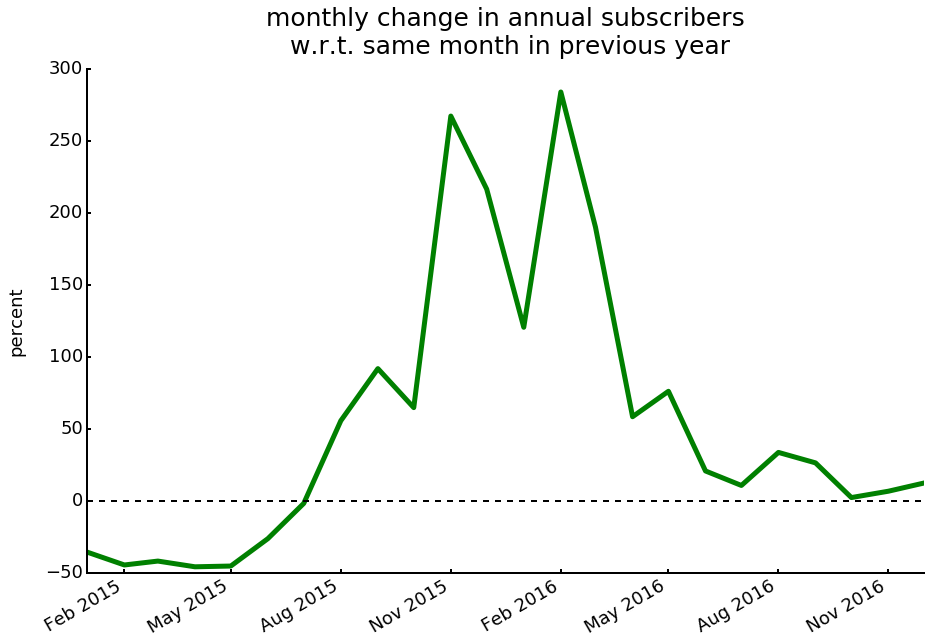

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(dates,growth_mom,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.ylabel('percent', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('monthly change in annual subscribers\n w.r.t. same month in previous year', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# highlight zero level

# highlight zero level
plt.plot([dates[0],dates[-1]],[0.,0.],ls='--',color='k',lw=2)




## Weekly total rides for subscribers

In [26]:
df = pd.read_csv(os.path.join(data_dir,'weekly_totals_subscriber.csv'))
# convert year and month to datetime object
df['date'] = df['yr'].apply(str) + '-' + df['wk'].apply(str)
# df['date'] = df['date'].apply(pd.to_datetime)
df.head()

,yr,wk,n_rides,date
0,2013,1,22228,2013-1
1,2013,27,99636,2013-27
2,2013,28,136203,2013-28
3,2013,29,162488,2013-29
4,2013,30,175960,2013-30


In [27]:
rides = df['n_rides'][df['yr'] >= 2014].tolist()
dates = df['date'][df['yr'] >= 2014].tolist()

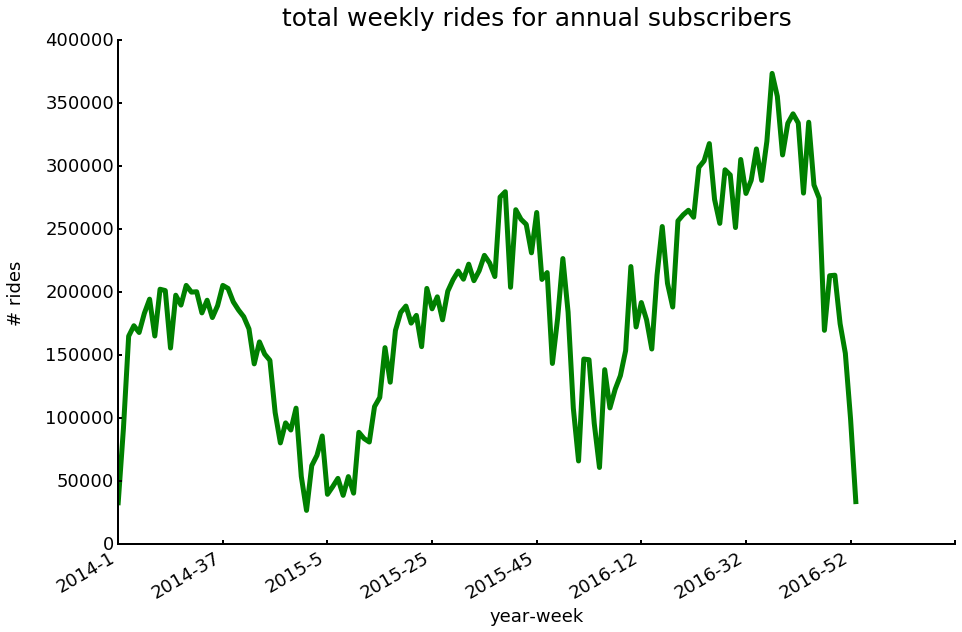

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(range(len(dates)),rides,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.ylabel('# rides', fontsize=18)
plt.xlabel('year-week', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('total weekly rides for annual subscribers', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Change xtick labels
ticks = [x for x in ax.get_xticks()]
int_ticks = [int(x) for x in ticks]
label_dates = [dates[x] for x in int_ticks[:-1]]
ax.set_xticklabels(label_dates)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')



## Weekly total rides for subscribers

In [29]:
df = pd.read_csv(os.path.join(data_dir,'weekly_totals_customers.csv'))
# convert year and month to datetime object
df['date'] = df['yr'].apply(str) + '-' + df['wk'].apply(str)
# df['date'] = df['date'].apply(pd.to_datetime)
df.head()

,yr,wk,n_rides,date
0,2013,1,1437,2013-1
1,2013,27,46735,2013-27
2,2013,28,36614,2013-28
3,2013,29,37008,2013-29
4,2013,30,39262,2013-30


In [30]:
rides = df['n_rides'][df['yr'] >= 2014].tolist()
dates = df['date'][df['yr'] >= 2014].tolist()

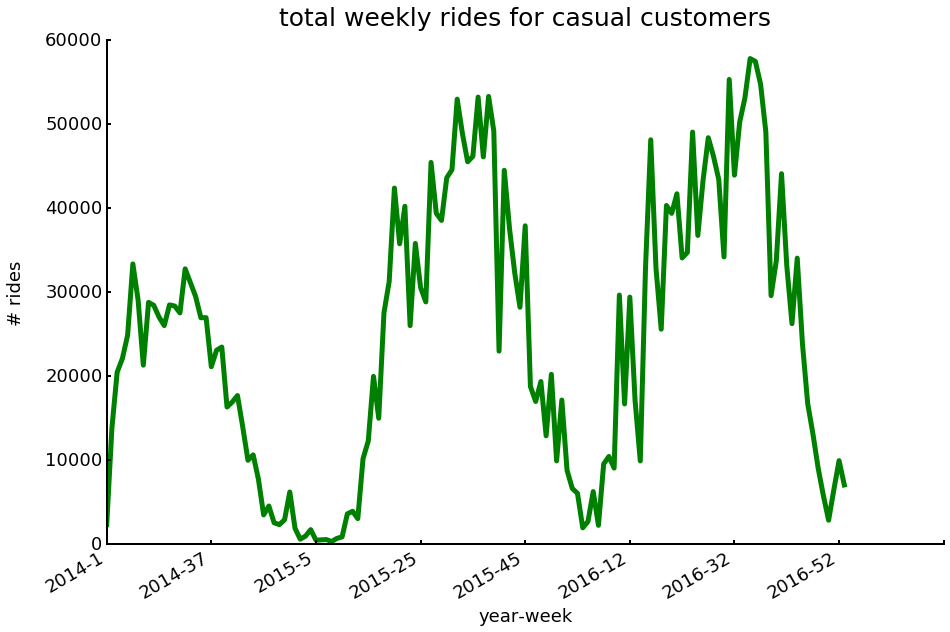

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(range(len(dates)),rides,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.ylabel('# rides', fontsize=18)
plt.xlabel('year-week', fontsize=18)
ax.yaxis.labelpad = 20
plt.title('total weekly rides for casual customers', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Change xtick labels
ticks = [x for x in ax.get_xticks()]
int_ticks = [int(x) for x in ticks]
label_dates = [dates[x] for x in int_ticks[:-1]]
ax.set_xticklabels(label_dates)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')



## Check rides taken per annual customer

In [32]:
df_sales = pd.read_csv(os.path.join(data_dir,'citibike_sales.csv'))
df_rides = pd.read_csv(os.path.join(data_dir,'monthly_totals_subscriber.csv'))

In [33]:
# convert year and month to datetime object
df_sales['date'] = df_sales['year'].apply(str) + '-' + df_sales['month'].apply(str)
df_sales['date'] = df_sales['date'].apply(pd.to_datetime)
# convert year and month to datetime object
df_rides['date'] = df_rides['yr'].apply(str) + '-' + df_rides['mth'].apply(str)
df_rides['date'] = df_rides['date'].apply(pd.to_datetime)

In [34]:
df_sales.head()

,year,month,yearly,weekly,three_day,daily,casual,active_annual_members,date
0,2013,6,26515,8044,0,67794,75838,52130,2013-06-01
1,2013,7,14185,5980,0,49021,55001,66315,2013-07-01
2,2013,8,10823,5244,0,51637,56881,77138,2013-08-01
3,2013,9,8103,4634,0,52045,56679,85241,2013-09-01
4,2013,10,7901,3386,0,34234,37620,93124,2013-10-01


In [35]:
df_rides.head()

,yr,mth,n_rides,date
0,2013,7,668501,2013-07-01
1,2013,8,815902,2013-08-01
2,2013,9,889190,2013-09-01
3,2013,10,940266,2013-10-01
4,2013,11,631801,2013-11-01


In [36]:
# Determine # of yearly passes sold per year
yearly_grouped = df_sales['yearly'].groupby(df_sales['year']).sum()
yearly_grouped

year
2013     70510
2014     77950
2015     91832
2016    119758
Name: yearly, dtype: int64

In [37]:
# Determine # of rides per year
n_rides_grouped = df_rides['n_rides'].groupby(df_rides['yr']).sum()
n_rides_grouped

yr
2013     4370245
2014     5752588
2015     8626638
2016    12301711
Name: n_rides, dtype: int64

In [38]:
# Rides per subscriber per year
for idx in yearly_grouped.index.tolist():
    tmp_sales = yearly_grouped.loc[idx]
    tmp_rides = n_rides_grouped.loc[idx]
    tmp_ratio = tmp_rides/tmp_sales
    print(idx,tmp_rides,tmp_sales,tmp_ratio)

2013 4370245 70510 61.98049922
2014 5752588 77950 73.7984348942
2015 8626638 91832 93.9393457618
2016 12301711 119758 102.721413183


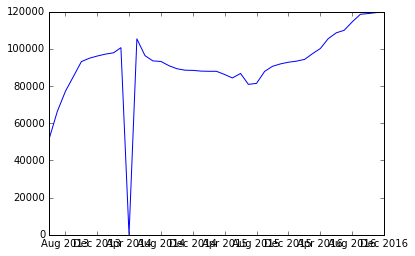

In [39]:
plt.plot(df_sales['date'],df_sales['active_annual_members'])

In [88]:
years = [2015,2016]
months = np.arange(12)+1
dates = []
ratios = []
for year in years:
    for month in months:
        condition = (df_sales['year'] == year) & (df_sales['month'] == month)
        tmp_aam = df_sales['active_annual_members'][condition].values
        dates.append(df_sales['date'][condition].values[0])
        condition = (df_rides['yr'] == year) & (df_rides['mth'] == month)
        tmp_nrides = df_rides['n_rides'][condition].values
        tmp_ratio = tmp_nrides/tmp_aam
        ratios.append(tmp_ratio[0])
        

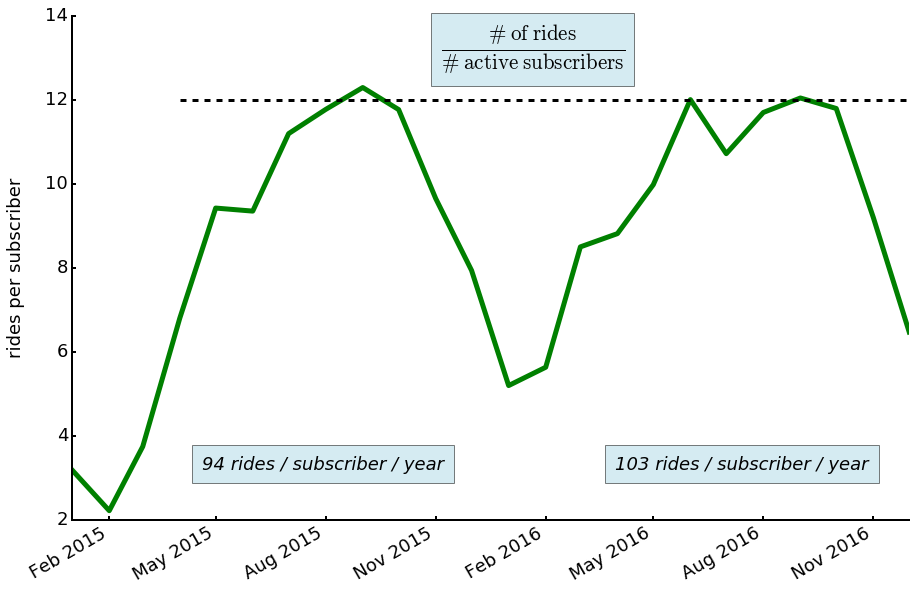

In [89]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(dates,ratios,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.ylabel('rides per subscriber', fontsize=18)
ax.yaxis.labelpad = 20
# plt.title('monthly rides per annual subscriber', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.plot([dates[3],dates[-1]],[12,12],'k--',lw=3)

ax.text(0.55, 0.92, '$\\frac{\\rm{\#\; of\; rides}}{\#\; active\; subscribers}$', style='italic',
        horizontalalignment='center', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
        transform=ax.transAxes,fontsize=30)

ax.text(0.3, 0.1, '94 rides / subscriber / year', style='italic',
        horizontalalignment='center', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
        transform=ax.transAxes,fontsize=18)
ax.text(0.8, 0.1, '103 rides / subscriber / year', style='italic',
        horizontalalignment='center', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
        transform=ax.transAxes,fontsize=18)


plt.savefig(os.path.join(data_dir,'plots','monthly_rides_per_subscriber.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(data_dir,'plots','monthly_rides_per_subscriber.png'), bbox_inches='tight')





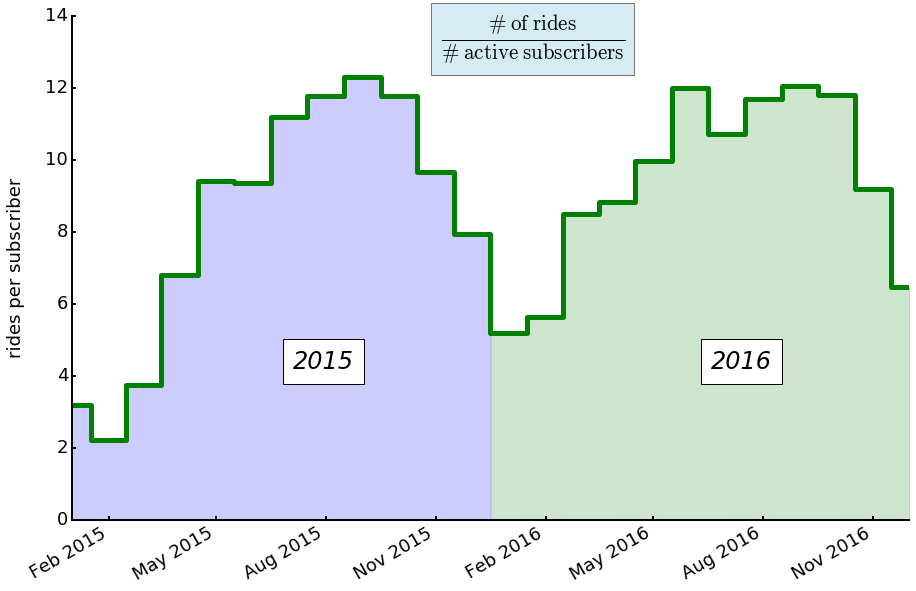

In [137]:
# Same as above but highlight years
#
fig, ax = plt.subplots(figsize=(15, 10))
#
width = 0.8       
# ax[0].fill_between(age[1], 0, [x/1e3 for x in male[1]], step='mid', color='b', alpha=0.2)
# rects1 = ax[0].step(age[1], [x/1e3 for x in male[1]], where='mid', color='b', label='2016', lw=3)

plt.step(dates,ratios,'g-', where='mid',alpha=1,lw=5)

# move filled area out by half a month to make them meet
tmp_dates = dates[0:12]
add = tmp_dates[-1]+np.timedelta64(15, 'D')
t = np.empty(len(tmp_dates)+1, dtype='datetime64[s]')
t[0:len(tmp_dates)] = tmp_dates
t[len(tmp_dates)] = add
#
tmp_ratio = ratios[0:12]
tmp_ratio.append(tmp_ratio[-1])
#
plt.fill_between(t, 0, tmp_ratio, step='mid',color='b', alpha=0.2)
#
tmp_dates = dates[12:]
add = tmp_dates[0]-np.timedelta64(15, 'D')
t = np.empty(len(tmp_dates)+1, dtype='datetime64[s]')
t[1:] = tmp_dates
t[0] = add
#
tmp_ratio = ratios[12:]
tmp_ratio.insert(0,tmp_ratio[0])
#
plt.fill_between(t, 0, tmp_ratio, step='mid',color='g', alpha=0.2)

#

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.ylabel('rides per subscriber', fontsize=18)
ax.yaxis.labelpad = 20
# plt.title('monthly rides per annual subscriber', fontsize=25,y=1.02)
# plt.grid(True)
ax.tick_params(labelsize=18)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ser witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# plt.plot([dates[3],dates[-1]],[12,12],'k--',lw=3)

ax.text(0.55, 0.94, '$\\frac{\\rm{\#\; of\; rides}}{\#\; active\; subscribers}$', style='italic',
        horizontalalignment='center', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
        transform=ax.transAxes,fontsize=30)

ax.text(0.3, 0.3, '2015', style='italic',
        horizontalalignment='center', bbox={'facecolor':'white', 'alpha':1, 'pad':10},
        transform=ax.transAxes,fontsize=24)
ax.text(0.8, 0.3, '2016', style='italic',
        horizontalalignment='center', bbox={'facecolor':'white', 'alpha':1, 'pad':10},
        transform=ax.transAxes,fontsize=24)


plt.savefig(os.path.join(data_dir,'plots','monthly_rides_per_subscriber.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(data_dir,'plots','monthly_rides_per_subscriber.png'), bbox_inches='tight')




